### Dimensionality Reduction?

Sometimes when we're analyzing data, we might find that the data is very highly dimensional, and we don't really know how to work with it. What techniques do we have for understanding very highly dimensional data? 

We could:
1. Use a random forest, which is designed for very highly dimensional data.
2. Try to fit a linear model to this.
3. Use an SVM, which also handles high dimensional data well.

So we actually have a lot of tools that are pretty robust on highly dimensional data! Unfortunately, our visualization skills are not necessarily up to par - even if we do get a great output from our models, we want to be able to interpret all of our data. Also, we might have hundreds or even thousands of useless, noisy features that we want to delete from our model because they either don't vary much, or are explained by other features.

So, we can use **Principle Components Analysis (PCA)** as a *dimensionality-reduction* technique. We can use it in the early stages of our pipeline to reduce the dimensionality of our data to make it easier to process, visualize, and think about. Let's see how it works.

### PCA in Principle
Basically, the idea behind PCA is that our data points $x_1, x_2, x_3, \ldots, x_N$ are tuples of highly dimensional data (so they're vectors in ${\mathbb R}^m$, where $m$ is a large number. We want to *summarize* this data with vectors $\phi_1, \phi_2, \ldots \phi_N \in {\mathbb R}^n$, where $n$ is much smaller than $m$. What does good summarization mean?

Let's say that the map from ${\mathbb R}^m \to {\mathbb R}^n$ is given by a matrix $M$ (we're looking for linear maps - notably, PCA is a *linear* dimensionality reduction technique. There are many nonlinear techniques, like locally linear embeddings (LLE) and Isomap, but we won't discuss them here). So, we know that $M$ is an $n \times m$ matrix, where we take a regular point $x_i \to Mx_i = \phi_i$. Then the columns of $M$ are the basis vectors of the transformation, but what are the rows? We're looking to find the ability of the map $M$ to summarize the data points $x_i$. 

One way to do this is to look at the row vectors of $M$, call them $\alpha_i$, and think of them as a partial basis of the space of all vectors. If we have $n = m$, then we can have a full basis, and the regular basis $e_1 = (1, 0, 0, \ldots), \ldots$ is perfectly fine, but since we're trying to do dimensionality reduction, we want to think about how much data we *can't* explain, or is contained in the complement subspace to the one we are looking at. Suppose our row vectors are $\alpha_i$, and suppose furthermore that they're orthonormal (orthogonality is crucial because we want as efficient a subspace as possible, and normality doesn't change our ability to explain the results). Then, the amount of *stuff in $x_i$* that can't be explained by the subspace is:
$$E_{\text{PCA}} = \sum_{i = 1}^N ||x_i - \sum_{j}(\alpha_j \cdot x_i)x_i||^2$$

where we're taking the dot product of $x_i$ with the basis, adding that together to form the *reconstructed* vector ($\sum_{j}(\alpha_j \cdot x_i)x_i$), and then finding the distance between that and the original, and summing the squares of those distances over all the vectors. We want to minimize this quantity.

It turns out (you can do the math!) that minimizing this quantity is equivalent to maximizing the covariance of the subspace, and we can find that by finding the top $n$ eigenvectors from the $m \times m$ covariance matrix of the data points:
$$C = \frac{1}{N}\sum_{i = 1}^N x_ix_i^T$$

So, once we extract the eigenvectors from this matrix, we can go ahead and build the matrix $M$, and then just map the points over as $\phi_i = Mx_i$, and we have our new 

How do we calibrate the value of $n$? In essence, how many dimensions can we reasonably drop from our data? While the ultimate answer will depend on your goals, one way to figure out what's going on is to look at *eigenspectrum*. This the list of the eigenvalues of $C$ in order, from largest to smallest. If 90% of the total sum of the eigenvalues is contributed by a few variables, those variables might be a good idea to keep, while dropping the rest. 

### Gotchas
PCA, while still used in many places, is often criticized for a few reasons:
1. It can lead to performance regression, sometimes in surprising ways, since we're just dropping major portions of our data.
2. It performs really badly when the features come from different scales, and tends to overweight the data with large scale data. So, **we often need to renormalize the data before applying PCA** since the scale of the variables matter.
3. 

David Mackay (of the famous [information theory and inference textbook](http://www.inference.phy.cam.ac.uk/itila/p0.html)) posted a scathing review of PCA [in an Amazon review comment](https://www.amazon.com/review/R16RJ2PT63DZ3Q/ref=cm_cr_rev_detmd_pl?ie=UTF8&asin=0521642981&cdForum=Fx37214P6NH2KSB&cdMsgID=Mx19BAIRVRARPZV&cdMsgNo=1&cdPage=1&cdSort=oldest&cdThread=Tx2OVZUUHW9MMJ9&store=books#Mx19BAIRVRARPZV), here:
> "Principal Component Analysis" is a dimensionally invalid method that gives people a delusion that they are doing something useful with their data. If you change the units that one of the variables is measured in, it will change all the "principal components"! It's for that reason that I made no mention of PCA in my book. I am not a slavish conformist, regurgitating whatever other people think should be taught. I think before I teach. David J C MacKay.

So maybe it's not the most rigorously useful technique. It does, however, still prove very useful while trying to visualize and understand our data.


### Let's apply it

Let's apply PCA as a preprocessing step to the digits classification task:

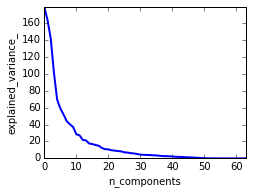

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets

# load data
digits = datasets.load_digits()
X = digits.data
y = digits.target

# load PCA
pca = decomposition.PCA()

# fit it! remember that this is an unsupervised technique so we're not passing in y
pca.fit(X)

# plot it
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [8]:
# let's use those components to fit our logistic regression
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train the dimensionality reduction for 20 output features
new_pca = decomposition.PCA(n_components=20)

# the dimensionality reduction can be trained on the entire X dataset
# just be careful never to use y_test in a train setting
new_pca.fit(X)
new_X_train = new_pca.transform(X_train)
new_X_test = new_pca.transform(X_test)

# let's train a logistic regressor
logistic = linear_model.LogisticRegression()
logistic.fit(new_X_train, y_train)

predicted = logistic.predict(new_X_test)

from sklearn import metrics
print("Classification report for classifier %s:\n%s\n"
      % (logistic, metrics.classification_report(y_test, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predicted))

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.91      0.91      0.91        35
          2       0.97      1.00      0.99        36
          3       0.97      0.97      0.97        29
          4       0.94      0.97      0.95        30
          5       0.89      0.97      0.93        40
          6       0.98      0.98      0.98        44
          7       0.95      0.95      0.95        39
          8       1.00      0.85      0.92        39
          9       0.95      0.95      0.95        41

avg / total       0.95      0.95      0.95       360


Confusion matrix:
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 3

[1] Saul, L., Weinberger, K., Ham, J., & Sha, F. (2006). Spectral methods for dimensionality reduction. Semisupervised Learning, 293–306. http://doi.org/10.1234/12345678